# Imports

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

from sklearn import preprocessing
from sklearn.model_selection import GroupShuffleSplit

import time

In [ ]:
tf.random.set_seed(0)

In [ ]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping: no known devices.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data loading

In [ ]:
path = "/content/drive/MyDrive/Thesis/Datasets/Pasteurizer_dataset/"

In [ ]:
train_df = pd.read_csv(path+ "centralized/train_set.csv")
test_df = pd.read_csv(path+ "centralized/test_set.csv")

In [ ]:
train_df

In [ ]:
test_df

# Preparing Data

In [ ]:
train_df

In [ ]:
# Shuffle rows
# train_df = train_df.sample(frac=1)

In [ ]:
# Use 80% for training and 20% for validation

valid_split = round(train_df.shape[0] * 0.8)
valid_split

37578

In [ ]:
# Train test numpy arrays
X_train_temp = train_df.drop(['curr_can_temp','paster_id'], axis=1).values
y_train_temp = train_df['curr_can_temp'].values


X_test = test_df.drop(['curr_can_temp','paster_id'], axis=1).values
y_test = test_df['curr_can_temp'].values

In [ ]:
# Min max normalizaiton

min_max_scaler = preprocessing.MinMaxScaler()

X_train_temp = min_max_scaler.fit_transform(X_train_temp)
X_test = min_max_scaler.fit_transform(X_test)


In [ ]:
X_train = X_train_temp[:valid_split, :]
y_train = y_train_temp[:valid_split]

X_valid = X_train_temp[valid_split:, :]
y_valid = y_train_temp[valid_split:]

In [ ]:
X_train_temp.shape

(46972, 6)

# Model Definition

In [ ]:
# Defining DNN model

model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(20,activation="relu",kernel_regularizer='l1_l2'))
model.add(tf.keras.layers.Dense(1))

# Training

In [ ]:
start = time.time()

model.compile(loss='mean_squared_error', optimizer="adam", metrics = 'mean_absolute_error')  # the model is recompiled to reset the optimizer
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=5,
                   batch_size=32,
                    callbacks=[callback]
                    )
end = time.time()
print(f"Training time {end - start:.2f} sec")

Epoch 1/5
1175/1175 [==============================] - 7s 4ms/step - loss: 864.4098 - mean_absolute_error: 22.1558 - val_loss: 11.6405 - val_mean_absolute_error: 2.5511
Epoch 2/5
1175/1175 [==============================] - 3s 3ms/step - loss: 9.1502 - mean_absolute_error: 1.9706 - val_loss: 5.7143 - val_mean_absolute_error: 1.4290
Epoch 3/5
1175/1175 [==============================] - 2s 2ms/step - loss: 6.6799 - mean_absolute_error: 1.4757 - val_loss: 5.4321 - val_mean_absolute_error: 1.3689
Epoch 4/5
1175/1175 [==============================] - 2s 2ms/step - loss: 6.2120 - mean_absolute_error: 1.4133 - val_loss: 5.0184 - val_mean_absolute_error: 1.3106
Epoch 5/5
1175/1175 [==============================] - 2s 2ms/step - loss: 5.4865 - mean_absolute_error: 1.3140 - val_loss: 4.3606 - val_mean_absolute_error: 1.1956
Training time 18.13 sec


# Evaluation

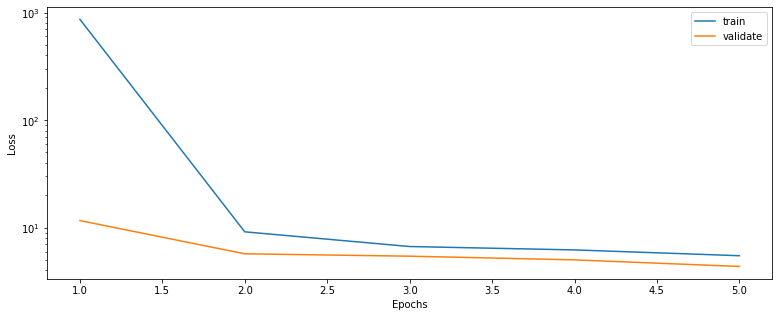

In [ ]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.yscale('log')
    plt.show()

plot_loss(history)

In [ ]:

def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = mean_squared_error(y_true, y_hat,squared=False)
    mae = mean_absolute_error(y_true, y_hat)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, MSE:{}, MAE:{}, R2:{}'.format(label, rmse, mse, mae, variance))

In [ ]:
# predict and evaluate
y_hat_train = model.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = model.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:1.9771742105154304, MSE:3.909217858727316, MAE:1.2480357429483686, R2:0.9565687665259432
test set RMSE:1.9184016493207798, MSE:3.6802648881166884, MAE:1.3815990667269527, R2:0.9600047698709484


In [ ]:
y_hat_train

array([[27.65979 ],
       [29.148212],
       [29.477797],
       ...,
       [55.094215],
       [54.96752 ],
       [54.811916]], dtype=float32)

In [ ]:
y_train

array([30.47, 30.61, 30.85, ..., 55.8 , 55.58, 55.29])

In [ ]:
y_hat_test

array([[27.352388],
       [28.262333],
       [28.785084],
       ...,
       [42.000217],
       [41.82977 ],
       [41.65887 ]], dtype=float32)

In [ ]:
y_test

array([28.1 , 28.27, 28.54, ..., 42.69, 42.41, 42.17])